<a href="https://colab.research.google.com/github/Manjuphoenix/ML_team_buzz/blob/michelle/prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prediction code for tomato

In [1]:
import numpy
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
import torch.optim as optim
from torch.utils.data import Subset
from torchvision.datasets import ImageFolder

torch.cuda.empty_cache()

In [2]:
!pip install kaggle

from google.colab import files 
files.upload()

#Make a directory named kaggle and copy the kaggle.json file there; and change its permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d manjuphoenix/tomatodataset

100% 920M/923M [00:35<00:00, 54.0MB/s]
100% 923M/923M [00:35<00:00, 27.6MB/s]


In [5]:
from zipfile import ZipFile
file_name = 'tomatodataset.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  #zip.printdir()
  print(zip.extractall())
  #zip.close()
  print('Done')

None
Done


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
])


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Uncomment the below line based on where you train the model----------------------------------------
# !mkdir /kaggle/working/Tomato

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Tomato* /kaggle/working/Tomato
# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Tomato* /kaggle/working/Tomato

# !rm -rf /kaggle/working/Tomato/Tomato___Leaf_Mold
# !rm -rf /kaggle/working/Tomato/Tomato___Tomato_mosaic_virus 

# Uncomment this for training on kaggle
# data = datasets.ImageFolder('/kaggle/working/Tomato', transform=transform)----------------------------


# This is for training on Local Machine
data = datasets.ImageFolder('/content/Tomato', transform=transform)


# Split into train/test sets:
train_len = int(len(data)*0.7)
train_set, test_set = random_split(data, [train_len, len(data) - train_len])

# Extract classes:
train_classes = [train_set.dataset.targets[i] for i in train_set.indices]
# Calculate support:
class_count = Counter(train_classes)
# Calculate class weights:
class_weights = torch.DoubleTensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
# Sampler needs the respective class weight supplied for each image in the dataset:
sample_weights = [class_weights[train_set.dataset.targets[i]] for i in train_set.indices]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=int(len(train_set)*2), replacement=True)

batch_size=32

# Create torch dataloaders:

dataloaders = DataLoader(data, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The total number of images is:", len(dataloaders))

train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a training set is:", len(train_loader)*batch_size)

val_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a test set is:", len(val_loader)*batch_size)
print(dataloaders.dataset)

print(data.classes)

cuda:0
The total number of images is: 2841
The number of images in a training set is: 90912
The number of images in a test set is: 19488
Dataset ImageFolder
    Number of datapoints: 64936
    Root location: /content/Tomato
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomGrayscale(p=0.1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
           )
['Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']


In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


tensor([[ 3.3225e+00, -5.7562e+00, -5.9395e+00,  3.0324e+00, -1.6571e+00,
          8.2445e-03, -4.2220e+00,  1.1371e+01]], grad_fn=<AddmmBackward0>)
7
Tomato__healthy


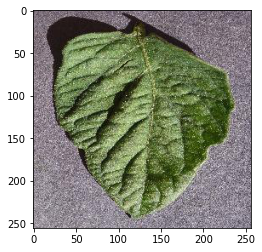

In [10]:
import torch
from torchvision.transforms import transforms
from PIL import Image
from pathlib import Path


#Creating a simple CNN architechture

# V3_tomato network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu = nn.LeakyReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=2)
        self.relu2 = nn.LeakyReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32*65*65, 1000)
        self.fc2 = nn.Linear(1000, 8)
        
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model = NeuralNetwork()
checkpoint = torch.load(Path('/content/gdrive/MyDrive/Copy of v3_tomato.pk1'))
model.load_state_dict(checkpoint)

# # Preprocess any image before passing it to the model
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(256),
])

        
    
        
# image = photo
image = Image.open(Path("/content/gdrive/MyDrive/Tomato_dataset/tHealthy.JPG"))
plt.imshow(image)

input = test_transform(image)

input = input.view(1, 3, 256,256)

output = model(input)
print(output)

prediction = int(torch.max(output.data, 1)[1].numpy())
print(prediction)

if (prediction == 0):
    print ('Tomato_Target_spot')
if (prediction == 1):
    print ('Tomato__Late_blight')
if (prediction == 2):
    print ('Tomato__Septoria_leaf_spot')
if (prediction == 3):
    print ('Tomato__Spider_mites')
if (prediction == 4):
    print ('Tomato___Bacterial_spot')
if (prediction == 5):
    print ('Tomato___Tomato_Yellow_Leaf_Curl_Virus')
if (prediction == 6):
    print ('Tomato__early_blight')
if (prediction == 7):
    print ('Tomato__healthy')

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
])


device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)

# This is for training on Local Machine
data = datasets.ImageFolder('Tomato', transform=transform)


# Split into train/test sets:
train_len = int(len(data)*0.7)
train_set, test_set = random_split(data, [train_len, len(data) - train_len])

# Extract classes:
train_classes = [train_set.dataset.targets[i] for i in train_set.indices]
# Calculate support:
class_count = Counter(train_classes)
# Calculate class weights:
class_weights = torch.DoubleTensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
# Sampler needs the respective class weight supplied for each image in the dataset:
sample_weights = [class_weights[train_set.dataset.targets[i]] for i in train_set.indices]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=int(len(train_set)*2), replacement=True)

batch_size=32

# Create torch dataloaders:

dataloaders = DataLoader(data, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The total number of images is:", len(dataloaders))

train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a training set is:", len(train_loader)*batch_size)

val_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a test set is:", len(val_loader)*batch_size)
print(dataloaders.dataset)

print(data.classes)

cuda:0
The total number of images is: 2841
The number of images in a training set is: 90912
The number of images in a test set is: 19488
Dataset ImageFolder
    Number of datapoints: 64936
    Root location: Tomato
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomGrayscale(p=0.1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
           )
['Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']


[[1898   32   19  193   43    3   63  105]
 [  32 1865   47   37  101   29  266   19]
 [ 119  182 1790   54   52   19  173   59]
 [ 267   24   27 1815   31   54  129   32]
 [   2   10    1    0 2492   56    1    0]
 [   5   15    0    6  166 2343    4    1]
 [ 136  320   58   65  109   47 1638    8]
 [  26    7    7   17   23    0    2 2337]]
[80.56027165 77.83806344 73.12091503 76.2925599  97.26775956 92.24409449
 68.79462411 96.61016949]


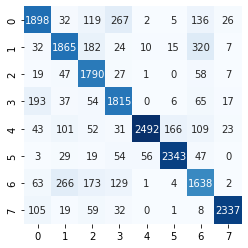

In [18]:
from sklearn.metrics import confusion_matrix

nb_classes = 8

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_loader):
        # inputs = inputs.to(device)
        # classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix_confusion = confusion_matrix(predlist, lbllist)
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

torch.Size([1, 3, 224, 224])
3
Healthy Apple Leaf


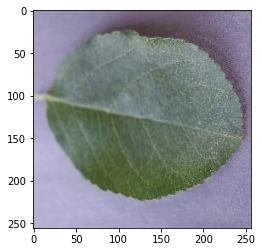

In [ ]:
class SimpleCustomCNN1(nn.Module):
    def __init__(self):
    super(SimpleCustomCNN1, self).__init__()

    #Defining a sequential model layers
    self.c1 = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels =8, kernel_size=5, padding=0, stride=1),
        nn.LeakyReLU(), 
        nn.MaxPool2d(kernel_size=2))
    self.c2 = nn.Sequential(
        nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size=3, padding=0, stride=1),
        nn.LeakyReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2))
    self.drop = nn.Dropout()
    self.fc = nn.Linear(in_features = 54*54*16, out_features = 4)
   
  def forward(self, x):
    output = self.c1(x)
    output = self.drop(output)
    output = self.c2(output)
    
    output = output.reshape(output.size(0), -1)
   
    output = self.drop(output)
    output = self.fc(output)
    return output



# model = NeuralNetwork()
# checkpoint = torch.load(Path('v3_tomato.pk1'))
# model.load_state_dict(checkpoint)

model = SimpleCustomCNN1()
checkpoint = torch.load(Path('final_year_project_model_apple.pk1'))

model.load_state_dict(checkpoint)


# # Preprocess any image before passing it to the model
# test_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.CenterCrop(256),
# ])

test_transform = transforms.Compose(
    [transforms.Resize(224),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

image = Image.open(Path("healthy.JPG"))

input = test_transform(image)

input = input.view(1, 3, 224, 224)
print(input.shape)


output = model(input)

prediction = int(torch.max(output.data, 1)[1].numpy())
print(prediction)


if (prediction == 0):
    print ('Apple Scab Disease')
if (prediction == 1):
    print ('Apple Black Rot Disease')
if (prediction == 2):
    print ('Cedar Apple Rust Disease')
if (prediction == 3):
    print ('Healthy Apple Leaf')
plt.imshow(image)